<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разбиение-данных-на-выборки-и-подготовка-дополнительных-признаков" data-toc-modified-id="Разбиение-данных-на-выборки-и-подготовка-дополнительных-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разбиение данных на выборки и подготовка дополнительных признаков</a></span></li><li><span><a href="#Обучение-модели-линейной-регрессии" data-toc-modified-id="Обучение-модели-линейной-регрессии-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение модели линейной регрессии</a></span></li><li><span><a href="#Обучение-модели-случайного-леса" data-toc-modified-id="Обучение-модели-случайного-леса-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение модели случайного леса</a></span></li><li><span><a href="#Обучение-модели-градиентного-бустинга" data-toc-modified-id="Обучение-модели-градиентного-бустинга-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Обучение модели градиентного бустинга</a></span></li><li><span><a href="#Показатели-обученных-моделей" data-toc-modified-id="Показатели-обученных-моделей-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Показатели обученных моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
display(data)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [4]:
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [5]:
data.duplicated().sum()

0

Дубликатов и пропусков нету - можем идти дальше

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Для начала переведём столбец с данными о времени в формат datetime64, а затем для удобства сделаем его новым индексом датафрейма, так как номер строки по сути не даёт нам в данном случае полезной информации

In [7]:
data['datetime'] = data['datetime'].astype('datetime64')

In [8]:
data.set_index('datetime', inplace=True)

In [9]:
display(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


## Анализ

Проверим что индексы указаны в хронологическом порядке

In [10]:
data.index.is_monotonic

True

Посмотрим на общую картину, которую даёт данный датафрейм

<AxesSubplot:xlabel='datetime'>

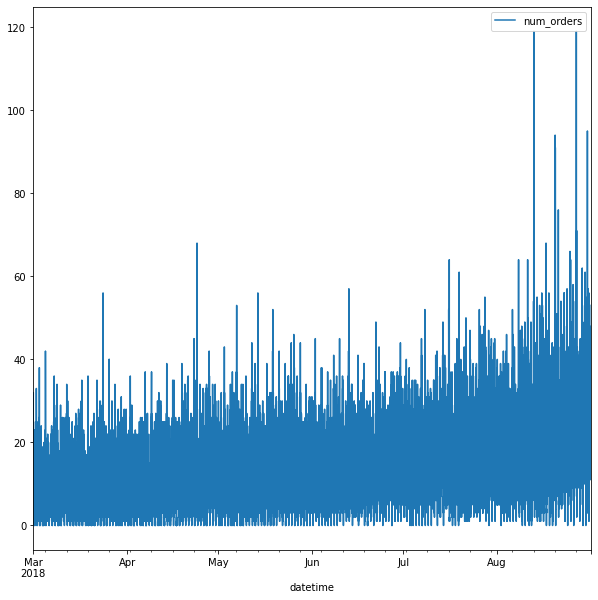

In [11]:
data.plot(figsize=(10, 10))

В исходном датафрейме слишком малый промежуток времени - 10 минут между каждым значением. Для того чтобы картина стала более читаемой и наглядной возьмём значения за 1 день - это сократит число значений на графике и позволит в более читаемом виде посмотреть динамику заказов

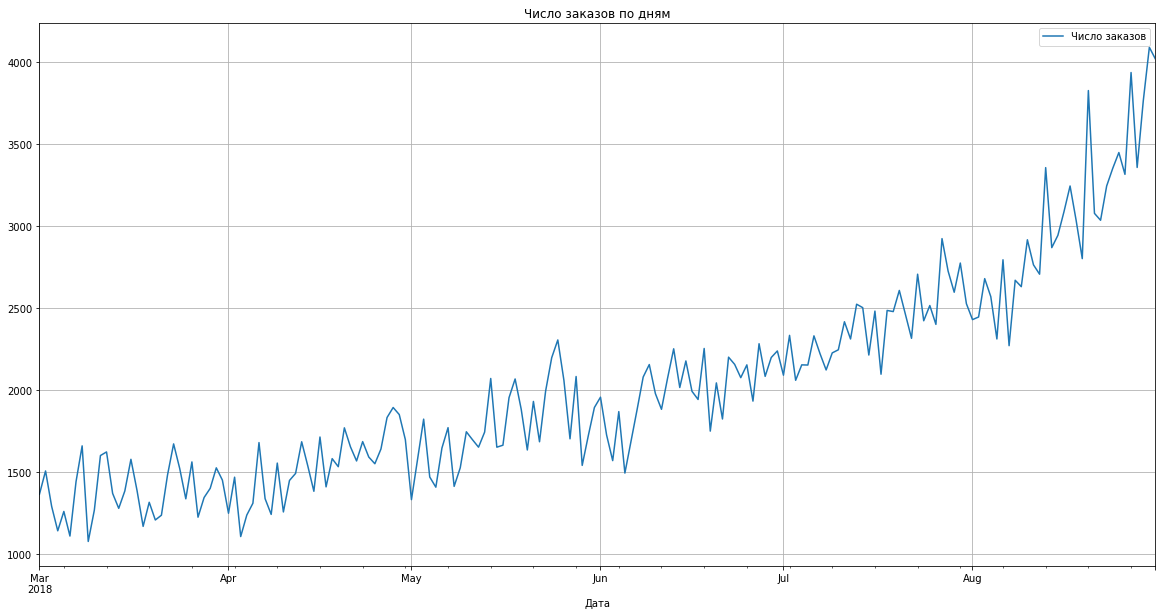

In [12]:
data.resample('1D').sum().plot(figsize=(20, 10), grid=True)
plt.title('Число заказов по дням')
plt.legend(['Число заказов'])
plt.xlabel('Дата');

Данные предсталены с первого дня весны по последний день лета - с 1 марта по 31 августа. Судя по графику можем сказать что заметен стабильный рост в числе заказов - видимо из-за летнего наплыва туристов или каких-то подобных факторов, которые увеличивают число потенциальных пользователей такси

In [13]:
decomposed = seasonal_decompose(data['num_orders'].resample('1H').sum())

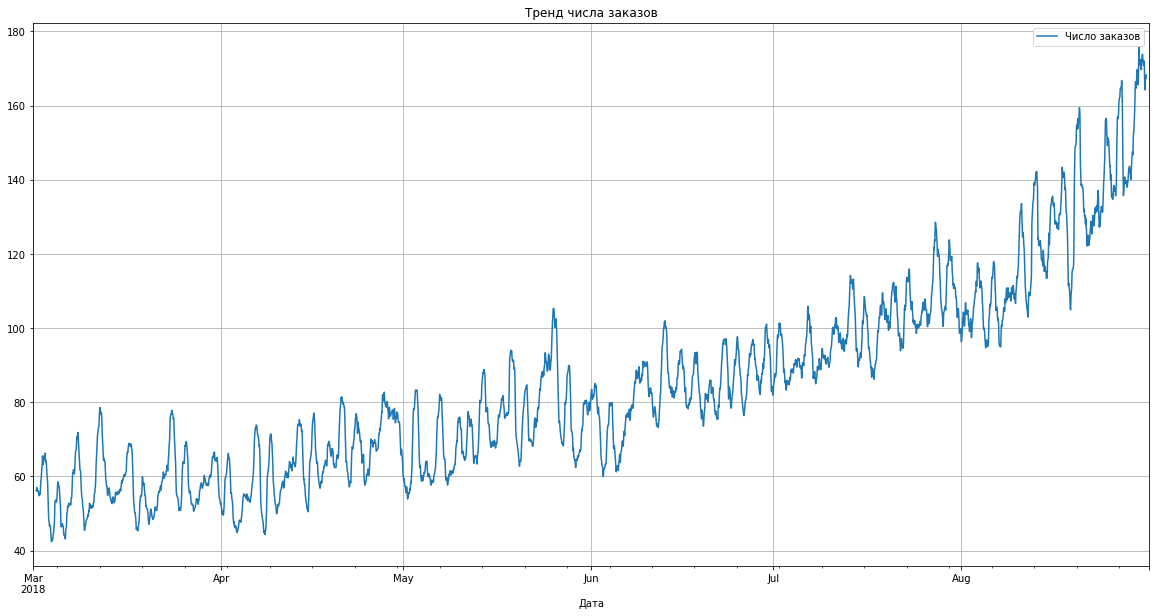

In [14]:
decomposed.trend.plot(figsize=(20, 10), grid=True)
plt.title('Тренд числа заказов')
plt.legend(['Число заказов'])
plt.xlabel('Дата');

Как и было указано ранее - число заказов в течение всей числовой прямой из предоставленных данных идёт на увеличение

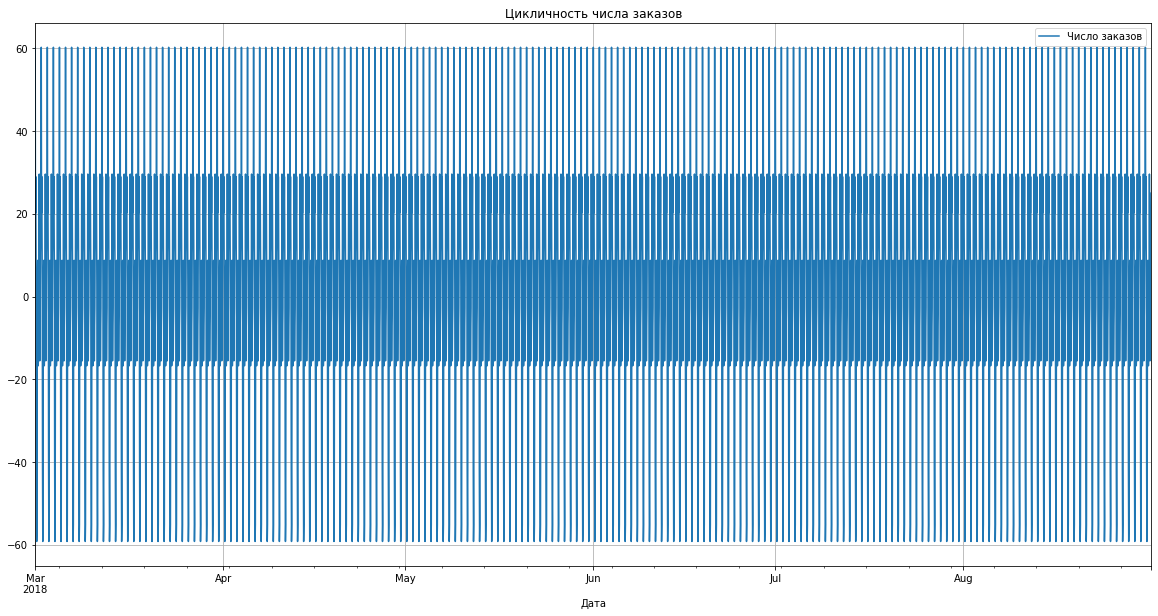

In [15]:
decomposed.seasonal.plot(figsize=(20, 10), grid=True)
plt.title('Цикличность числа заказов')
plt.legend(['Число заказов'])
plt.xlabel('Дата');

Для понимания периода цикличности резонно будет рассмотреть какой-то более мелкий диапазон. Например неделя

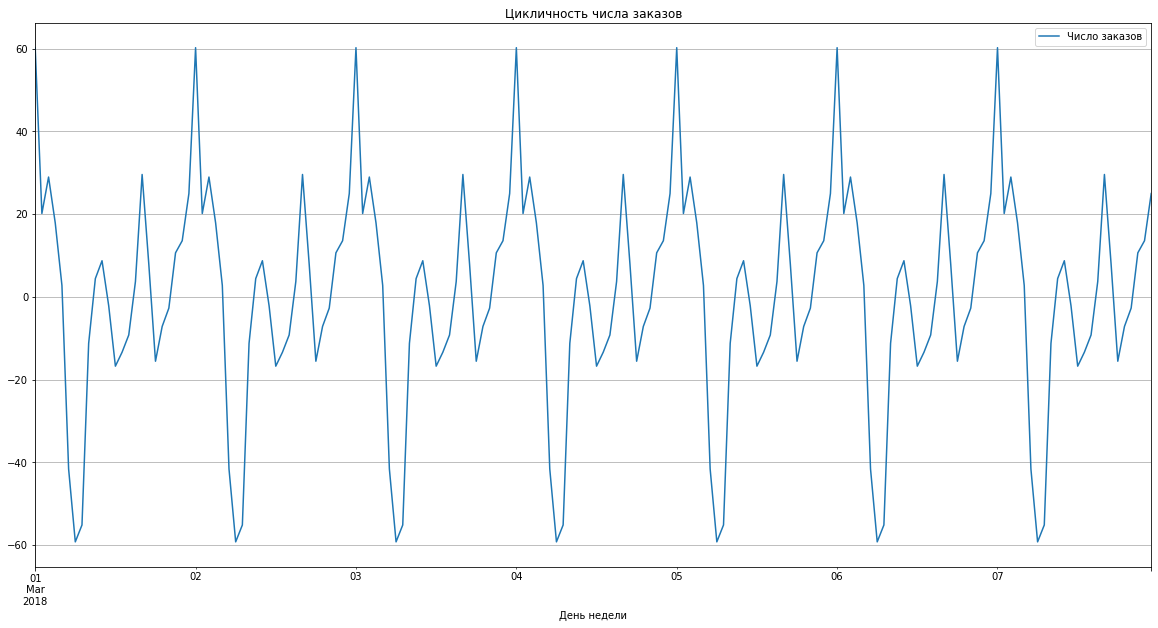

In [16]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(figsize=(20, 10), grid=True)
plt.title('Цикличность числа заказов')
plt.legend(['Число заказов'])
plt.xlabel('День недели');

Можем заметить, что один цикл занимает примерно сутки - сузим рассматриваемый диапзазон до дня

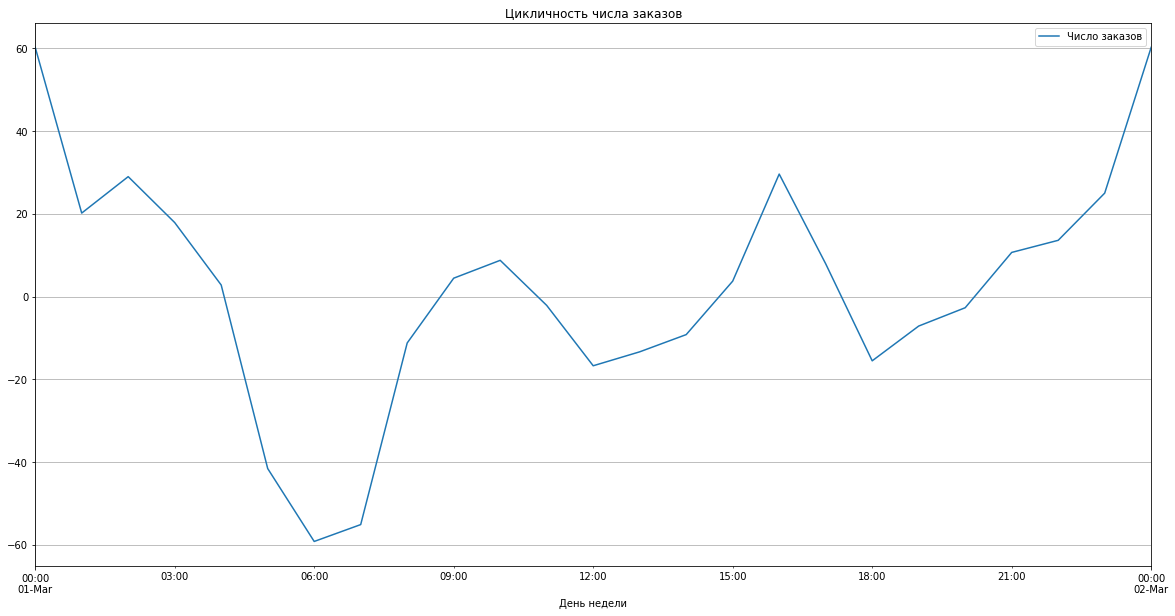

In [17]:
decomposed.seasonal['2018-03-01 00:00':'2018-03-02 00:00'].plot(figsize=(20, 10), grid=True)
plt.title('Цикличность числа заказов')
plt.legend(['Число заказов'])
plt.xlabel('День недели');

Теперь можем сказать, что пиковые значения вызовов такси наблюдаются в районе полуночи, спад активности - около 6 утра. Локальный максимум активности так же показывают 10:00 и 16:00 - не совсем близко к реальности, но тем не менее в рамках исследованя можно предположить, что примерно в это время люди едут на/после работы, и как раз поскольку они находятся на работе - между этими максимумами наблюдается спад, - такси перестают так активно заказывать, так как все сидят в офисах

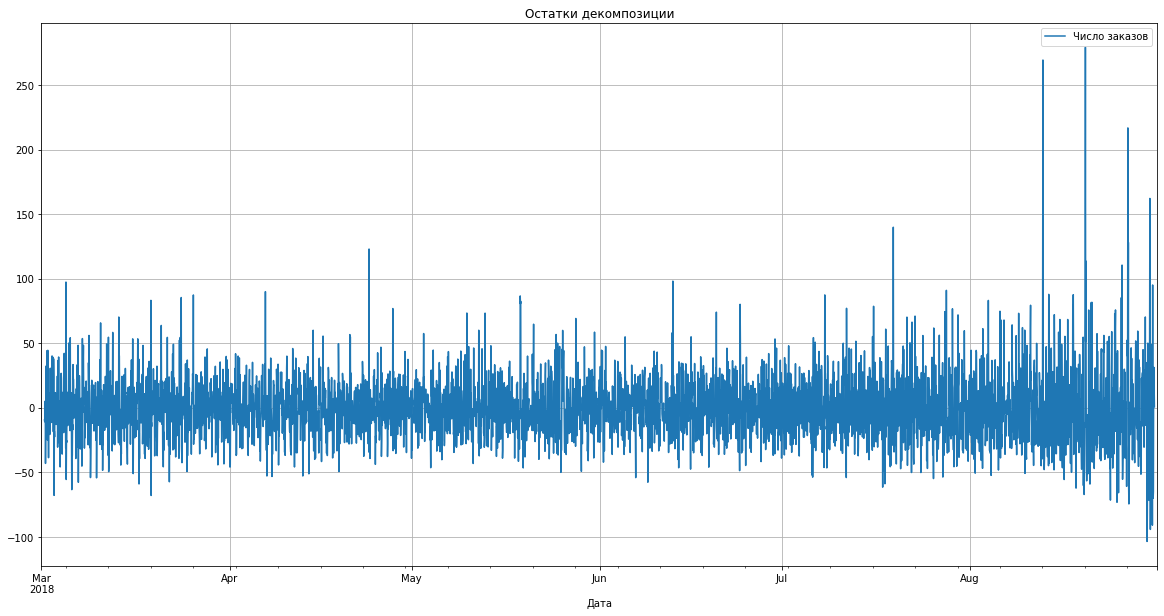

In [18]:
decomposed.resid.plot(figsize=(20, 10), grid=True)
plt.title('Остатки декомпозиции')
plt.legend(['Число заказов'])
plt.xlabel('Дата');

## Обучение

### Разбиение данных на выборки и подготовка дополнительных признаков

Так как нас интересуют предсказания на следующий час, то сделаем ресемплирование по часу:

In [19]:
data_resampled = data.resample('1H').sum()

Напишем функцию, которая создаст дополнительные признаки для обучения: месяц, день месяца, день недели и час, а так же добавит отстающие значения. По этому дополнительному набору данных модель сможет сделать предсказания более точными. 

In [20]:
def make_features(data, max_lag):
    bonus_features_data = data.copy(deep = True)
    bonus_features_data['month'] = data.index.month
    bonus_features_data['day'] = data.index.day
    bonus_features_data['dayofweek'] = data.index.dayofweek
    bonus_features_data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        bonus_features_data['lag_{}'.format(lag)] = bonus_features_data['num_orders'].shift(lag)
        
    return bonus_features_data

Чем больше будет отстающих значений, тем болше будет разрастаться датафрейм, и тем дольше времени займет обучение, но как показала практика только на действительно большом наборе данных удалось добиться нужного значения метрики - поэтому по итогу данный параметр дошел до целых 15

In [21]:
bonus_features_data = make_features(data_resampled, 15)

Отделим от данных тестовую выборку. По условию она должна быть 10 %. Учтём тот факт, что данные нельзя перемешивать, так как в противном случае собьется хронология

In [22]:
train, test = train_test_split(bonus_features_data, shuffle=False, test_size=0.1)

Удалим пропущенные строки из тренировочной выборки, который получились из-за введения признаков отстающих значений

In [23]:
train = train.dropna()

In [24]:
print(f'Временной диапазон обучающих данных: с {train.index.min()} до {train.index.max()} ')

Временной диапазон обучающих данных: с 2018-03-01 15:00:00 до 2018-08-13 13:00:00 


In [25]:
print(f'Временной диапазон тестовых данных: с {test.index.min()} до {test.index.max()} ')

Временной диапазон тестовых данных: с 2018-08-13 14:00:00 до 2018-08-31 23:00:00 


Получается, задача будет по сути состоять в том, чтобы предсказать кол-во заказов такси в последние 2 недели августа

Внутри тренировочной выборки сделаем так же разделение на 90% и 10 % для создания валидационной выборки, на которой можно будет проверять модели перед финальным тестированием

In [26]:
train, valid = train_test_split(train, shuffle=False, test_size=0.1)

Посмотрим на то какие выборки получились

In [27]:
display(train)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,,,,,,
2018-03-01 15:00:00,66,3,1,3,15,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-01 16:00:00,43,3,1,3,16,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-01 17:00:00,44,3,1,3,17,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-01 18:00:00,73,3,1,3,18,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-01 19:00:00,45,3,1,3,19,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-27 21:00:00,133,7,27,4,21,131.0,86.0,76.0,160.0,162.0,113.0,61.0,144.0,118.0,110.0,149.0,139.0,89.0,44.0,78.0
2018-07-27 22:00:00,213,7,27,4,22,133.0,131.0,86.0,76.0,160.0,162.0,113.0,61.0,144.0,118.0,110.0,149.0,139.0,89.0,44.0
2018-07-27 23:00:00,122,7,27,4,23,213.0,133.0,131.0,86.0,76.0,160.0,162.0,113.0,61.0,144.0,118.0,110.0,149.0,139.0,89.0


In [28]:
display(valid)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,,,,,,
2018-07-28 02:00:00,145,7,28,5,2,195.0,192.0,122.0,213.0,133.0,131.0,86.0,76.0,160.0,162.0,113.0,61.0,144.0,118.0,110.0
2018-07-28 03:00:00,132,7,28,5,3,145.0,195.0,192.0,122.0,213.0,133.0,131.0,86.0,76.0,160.0,162.0,113.0,61.0,144.0,118.0
2018-07-28 04:00:00,215,7,28,5,4,132.0,145.0,195.0,192.0,122.0,213.0,133.0,131.0,86.0,76.0,160.0,162.0,113.0,61.0,144.0
2018-07-28 05:00:00,91,7,28,5,5,215.0,132.0,145.0,195.0,192.0,122.0,213.0,133.0,131.0,86.0,76.0,160.0,162.0,113.0,61.0
2018-07-28 06:00:00,44,7,28,5,6,91.0,215.0,132.0,145.0,195.0,192.0,122.0,213.0,133.0,131.0,86.0,76.0,160.0,162.0,113.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,137,8,13,0,9,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0
2018-08-13 10:00:00,156,8,13,0,10,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,185.0,118.0,135.0,98.0,82.0
2018-08-13 11:00:00,144,8,13,0,11,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,185.0,118.0,135.0,98.0


In [29]:
display(test)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,102,8,13,0,14,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0,185.0
2018-08-13 15:00:00,175,8,13,0,15,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,160.0
2018-08-13 16:00:00,144,8,13,0,16,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0
2018-08-13 17:00:00,152,8,13,0,17,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0
2018-08-13 18:00:00,104,8,13,0,18,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0,268.0
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0,78.0
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0,35.0


Выделим в выборках целевой и обучающий признаки:

In [30]:
train_features = train.drop(['num_orders'], axis = 1)
train_target = train['num_orders']
valid_features = valid.drop(['num_orders'], axis = 1)
valid_target = valid['num_orders']
test_features = test.drop(['num_orders'], axis = 1)
test_target = test['num_orders']

Теперь можно приступить к обучению моделей. Судя по графику зависимости числа заказов от времени сюда подойдет линейная регрессия. Так же попробуем случайный лес и Catboost

### Обучение модели линейной регрессии

In [31]:
linear_regressor_model = LinearRegression()

In [32]:
linear_regressor_model.fit(train_features, train_target);

In [33]:
linear_regressor_predictions = linear_regressor_model.predict(valid_features)

In [34]:
rmse_linear_regressor = mean_squared_error(valid_target, linear_regressor_predictions)**0.5

In [35]:
print(f'Метрика RMSE модели линейной регрессии на валидационных данных: {rmse_linear_regressor:.3f}')

Метрика RMSE модели линейной регрессии на валидационных данных: 39.823


Как видно предположение о том, что модель линейной регрессии хорошо сработает в данной ситуации, оказалось верным - получили значение RMSE сразу же лучше чем требуемые 48. Тем не менее посмотрим как себя покажут и другие модели

### Обучение модели случайного леса

In [36]:
random_forest_model = RandomForestRegressor(random_state = 12345)

In [37]:
# зададим гиперпараметры для перебора:

max_depth = [i for i in range(1, 11)]
max_trees = [i for i in range(1, 11)]

forest_params  = {'max_depth' : max_depth,
                  'n_estimators' : max_trees}

In [38]:
tscv = TimeSeriesSplit(n_splits=5)

In [39]:
forest_grid_model = GridSearchCV(random_forest_model, forest_params, cv=tscv, scoring = 'neg_mean_squared_error', n_jobs = -1)

In [40]:
forest_grid_model.fit(train_features, train_target);

In [41]:
random_forest_predictions = forest_grid_model.predict(valid_features)

In [42]:
rmse_random_forest = mean_squared_error(valid_target, random_forest_predictions)**0.5

In [43]:
print(f'Метрика RMSE модели случайного леса на валидационных данных: {rmse_random_forest:.3f}')

Метрика RMSE модели случайного леса на валидационных данных: 31.493


После перебора гиперпараметров модель случайного леса показала себя даже лучше, чем линейная регрессия. Посмотрим какие успехи будут у модели градиентного бустинга

### Обучение модели градиентного бустинга

In [44]:
cat_regressor_model = CatBoostRegressor(loss_function = 'RMSE', random_state = 12345, verbose = False)

In [45]:
# зададим гиперпараметры для перебора:

learning_rate = [0.05, 0.1, 0.15]
max_depth = [i for i in range(1, 5)]
iteration = [i for i in range(500, 1101, 200)]

In [46]:
parameters = {'depth' : max_depth, 'learning_rate' : learning_rate, 'iterations' : iteration}

In [47]:
cat_grid_model = GridSearchCV(cat_regressor_model, parameters, cv=tscv, n_jobs = -1)

In [48]:
cat_grid_model.fit(train_features, train_target);

In [49]:
cat_grid_model.best_params_

{'depth': 4, 'iterations': 500, 'learning_rate': 0.1}

In [50]:
cat_model_predictions = cat_grid_model.predict(valid_features)

In [51]:
rmse_cat_model = mean_squared_error(valid_target, cat_model_predictions)**0.5

In [52]:
print(f'Метрика RMSE модели градиентного бустинга на валидационных данных: {rmse_cat_model:.3f}')

Метрика RMSE модели градиентного бустинга на валидационных данных: 31.365


### Показатели обученных моделей

Создадим итоговый датафрейм со всеми показателями моделей:

In [53]:
stats = {'RMSE' : [rmse_linear_regressor, rmse_random_forest, rmse_cat_model]}

model_names = ['linear_regression', 'random_forest', 'catboost']

models_stats_data = pd.DataFrame(stats, index = model_names)

In [54]:
display(models_stats_data)

,RMSE
linear_regression,39.822737
random_forest,31.492912
catboost,31.364605


Как видно, модель градиентного бустинга справилась лучше всех, её и будем использовать на тестовой выборке

Ради интереса посмотрим какую метрику RMSE показывает глупая модель, выдающая просто среднее значение:

In [55]:
dummy_model = DummyRegressor(strategy='mean')

In [56]:
dummy_model.fit(train_features, train_target);

In [57]:
predictions_dummy_model = dummy_model.predict(valid_features)

In [58]:
rmse_dummy_model = mean_squared_error(valid_target, predictions_dummy_model)**0.5

In [59]:
print(f'Метрика RMSE глупой модели, которая просто предсказывала средние значения из обучающей выборки: {rmse_dummy_model:.3f}')

Метрика RMSE глупой модели, которая просто предсказывала средние значения из обучающей выборки: 57.908


Как и ожидалось, обученные модели все прошли проверку на адекватность: глупая модель показывает гораздо худший результат

## Тестирование

Протестируем ранее выбранную в качестве лучшей модель градиентного бустинга

In [60]:
catboost_predictions = cat_grid_model.predict(test_features)
rmse_cat_grid_model = mean_squared_error(test_target, catboost_predictions)**0.5

In [61]:
print(f'Метрика RMSE модели градиентного бустинга на тестовых данных: {rmse_cat_grid_model:.3f}')

Метрика RMSE модели градиентного бустинга на тестовых данных: 47.877


In [62]:
if rmse_cat_grid_model < 48 :
    print('Модель удовлетворяет требованиям качества')
else:
    print('Модель не удовлетворяет требованиям качества')

Модель удовлетворяет требованиям качества


Как и ожидалось, модель показала себя достойно, и попала в требуемый диапазон качества

Визуализируем предсказанные моделью значения на фоне настоящих:

In [63]:
values = {'predictions' : catboost_predictions, 'real_values' : test_target}

date = test.index

predictions_vs_real_values = pd.DataFrame(values, index = date)

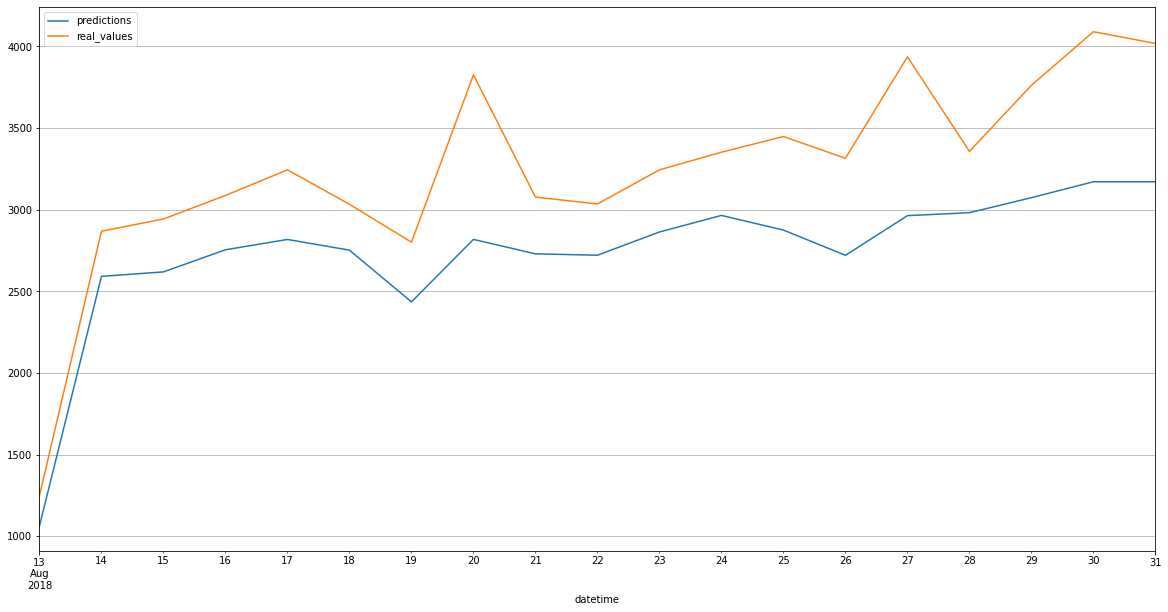

In [64]:
predictions_vs_real_values.resample('1D').sum().plot(figsize=(20, 10), grid=True);

Можем сказать, что модель недооценила прирост числа заказов, и в конце лета он пошел даже более стремительными темпами, чем в тот период, на котором тренировалась модель делать предсказания - наблюдается фактичски постоянная разность между предсказаниями модели и реальными значениями заказов такси, которых оказывалось на несколько сотен больше каждый день